In [1]:
import numpy as np
import xarray as xr
import ac3airborne
import matplotlib.pyplot as plt
import datetime
import src
import typhon as ty
# use typhon ploting style
plt.style.use(ty.plots.styles.get('typhon'))

/net/secaire/mringel/.conda/envs/ac3env/lib/python3.10/site-packages/typhon/nonlte/rtc/__init__.py:9: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def FOSC(tau, Sb, Sm, Ib):


In [2]:
cat = ac3airborne.get_intake_catalog() # intake catalogues
meta = ac3airborne.get_flight_segments() # flight segmentation

In [3]:
cat, meta, credentials = src.get_ac3_meta()

P5_all_campaigns = xr.open_dataset('/net/secaire/mringel/data/lwp_retrieved/all_campaigns_P5_lwp_v3.nc')

campaigns = list(cat)

del campaigns[1]
del campaigns[-1]

ValueError: too many values to unpack (expected 3)

In [ ]:
time_offset = 15 # seconds
spatial_avg = 30 # seconds

for campaign in ['ACLOUD', 'AFLUX', 'MOSAiC-ACA']:
     for platform in ['P5']:
          for flight_id in list(cat[campaign]['P5']['CLOUD_TOP_HEIGHT']):
                
            if flight_id == 'ACLOUD_P5_RF04':
                amali_all_campaigns = cat[campaign]['P5']['CLOUD_TOP_HEIGHT'][flight_id].to_dask()
            else:
                amali = cat[campaign]['P5']['CLOUD_TOP_HEIGHT'][flight_id].to_dask()
                amali_all_campaigns = xr.concat([amali_all_campaigns,amali],dim='time')

# add 16s as timelag to AMALi measurements to approx. compensate viewing angle difference to MiRAC
amali_all_campaigns.update({'time':amali_all_campaigns.time + np.timedelta64(time_offset,'s')})
# make a moving average over AMALi measurements to approx. compensate footprintsize to MiRAC
amali_all_campaigns = amali_all_campaigns.rolling(time=spatial_avg,center=True).mean()

cloud_mask = amali_all_campaigns.cloud_mask

In [5]:
P5_all_campaigns = P5_all_campaigns.sel(time=slice(P5_all_campaigns.time.values[0],cloud_mask.time.values[-1]),drop=True)
cloud_mask = cloud_mask.sel(time=slice(P5_all_campaigns.time.values[0],cloud_mask.time.values[-1]),drop=True)
P5_all_campaigns = P5_all_campaigns.reindex(time=cloud_mask.time)

In [6]:
P5_clear_sky = P5_all_campaigns.where(cloud_mask==1,drop=True)

In [7]:
clearsky_mean = P5_clear_sky.lwp.mean().values*1000
clearsky_std = P5_clear_sky.lwp.std().values*1000

Text(0.5, 0.98, 'Clearsky cases')

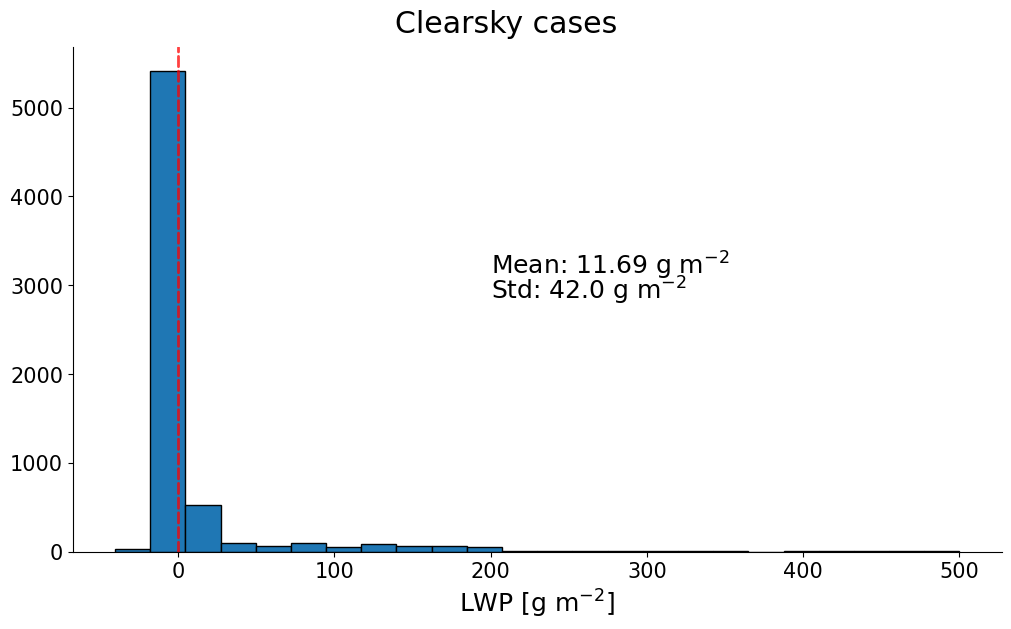

In [8]:
fig, ax = plt.subplots()

lwp_range = [-100,500]
bins = 24

ax.hist(np.clip(P5_clear_sky.lwp*1000,lwp_range[0],lwp_range[1]),bins=bins,ec='black')

ax.axvline(x=0,linestyle='dashed',color='red',alpha=0.75)

ax.text(0.45,0.55,'Mean: '+str(np.round(clearsky_mean,2))+' g m$^{-2}$',transform=ax.transAxes)
ax.text(0.45,0.5,'Std: '+str(np.round(clearsky_std,2))+' g m$^{-2}$',transform=ax.transAxes)

ax.set_xlabel('LWP [g m$^{-2}$]')

fig.suptitle('Clearsky cases')

#plt.savefig('/home/mringel/lwp_project/figures/retrieval_clearsky_noise.png',
#            bbox_inches='tight',
#            dpi=200)